# Titanic
---

Final project for Udacity *Intro to Data Science*

Data desciptions are on [Kaggle](https://www.kaggle.com/c/titanic/data)

## What factors affected survival rates?
---

I expect that passangers who were housed nearer to the top of the Titanic were more likely to survive since they would have less distance to travel to the lifeboats. I would also expect women to have survived more often since 'women and children' policies tend to happen in emergency situations

In [2]:
# Load the data and examine
import pandas as pd

titanic_data_df = pd.read_csv('titanic_data.csv')

# Check that passenger ids are unique --> ok for index
print 'Number of elems', len(titanic_data_df), len(titanic_data_df['PassengerId'].unique())
titanic_data_df.set_index('PassengerId', inplace=True)

print titanic_data_df.head(3)

Number of elems 891 891
             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  


## Preliminary Data Analysis
---

What values are present?

*SibSp* is siblings and spouses aboard

*Parch* is number of parents/children aboard

*Embark* is Cherbourg, Queenstown or Southampton

In [3]:
def print_value_counts(col_name):
    df = titanic_data_df[col_name].value_counts()
    print df.name, ':', 'Percent non-NaN', df.sum() * 1.0 / len(titanic_data_df)
    print df
    print

print_value_counts('Survived')
print_value_counts('Pclass')
print_value_counts('Sex')
print_value_counts('SibSp')
print_value_counts('Parch')
print_value_counts('Embarked')

Survived : Percent non-NaN 1.0
0    549
1    342
Name: Survived, dtype: int64

Pclass : Percent non-NaN 1.0
3    491
1    216
2    184
Name: Pclass, dtype: int64

Sex : Percent non-NaN 1.0
male      577
female    314
Name: Sex, dtype: int64

SibSp : Percent non-NaN 1.0
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Parch : Percent non-NaN 1.0
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Embarked : Percent non-NaN 0.997755331089
S    644
C    168
Q     77
Name: Embarked, dtype: int64



/Users/sebarton/Documents/Personal/udacity-courses/intro-to-data-analysis/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Age : Percent non-NaN 0.801346801347
Fare : Percent non-NaN 1.0


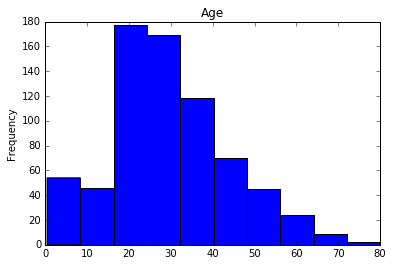

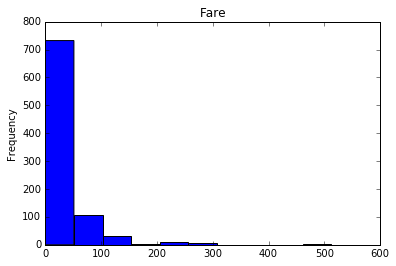

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
titanic_data_df['Age'].plot(kind='hist', title='Age')
print 'Age : Percent non-NaN', titanic_data_df['Age'].count() * 1.0 / len(titanic_data_df)

plt.figure()
titanic_data_df['Fare'].plot(kind='hist', title='Fare')
print 'Fare : Percent non-NaN', titanic_data_df['Fare'].count() * 1.0 / len(titanic_data_df)


## Examine Linearity in Data
---

Assume initially that the data is linearly seperable


Start with a scatterplot matrix to see if data is seperable over any pairs of numeric values

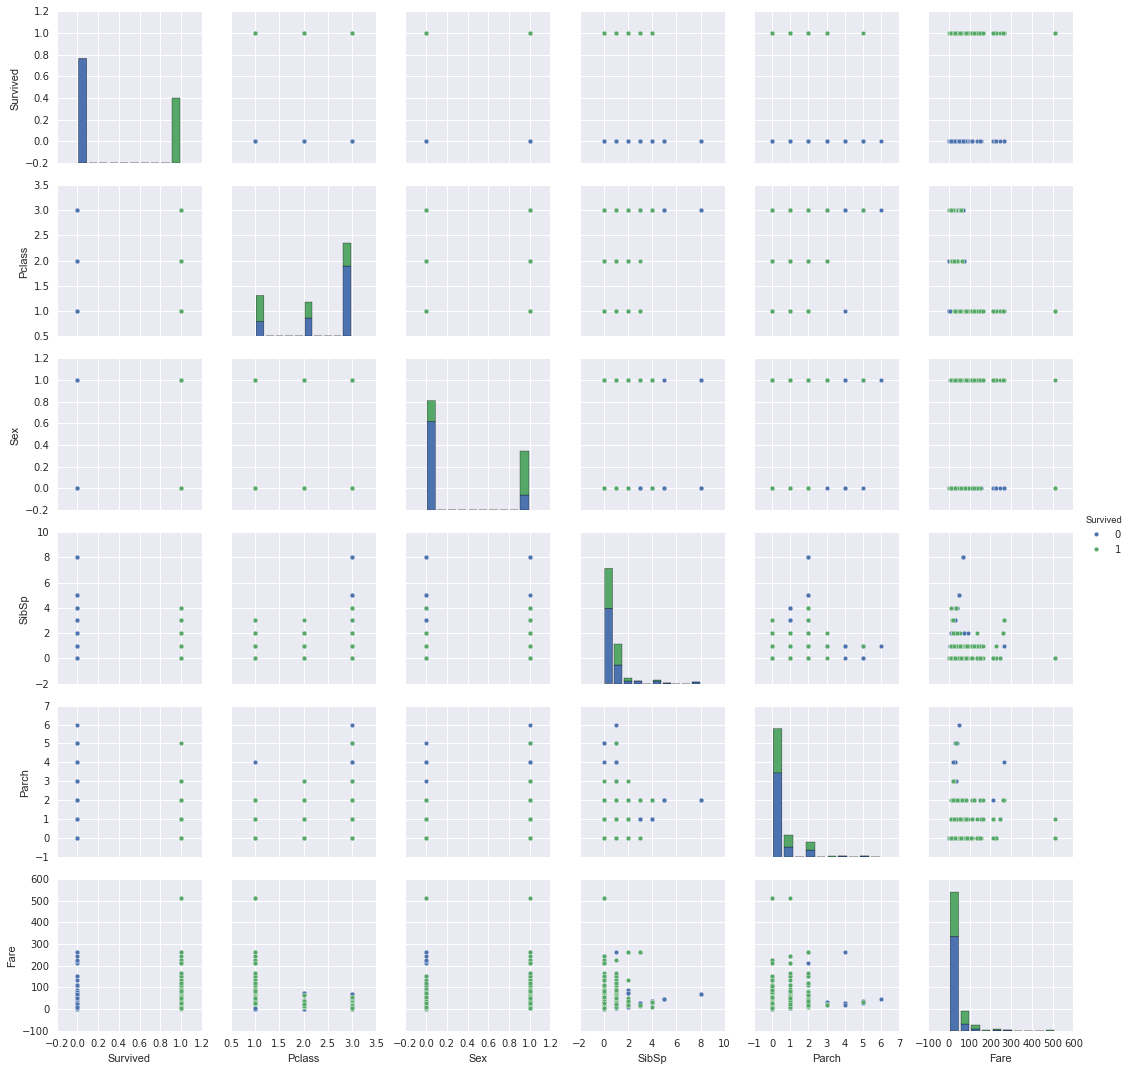

In [5]:
import seaborn as sns
sns.set()

# Convert sex and origin to numeric
numeric_data_df = titanic_data_df[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']].copy()

sex_map = {'male':0, 'female':1}
numeric_data_df['Sex'] = numeric_data_df['Sex'].map(sex_map)

# Plot
sns.pairplot(numeric_data_df, hue='Survived')

### Thoughts so far

Some observations:
- The center histograms point out that no single variable is completely seperable
- A far larger percentage of women survived
- No single pairing seems to be completely seperable
- The combination of sex and fare points to a group in the 200-300 fare range where the men died and the women survived
- Having childen also seems to help survival chances

I'll now try a decision tree on the whole set to help seperate out the most influencial factors

### Decision Tree

I'll utilize a decision tree to seperate the data by the most seperable variables. This will provide insight into which variables are most important. The top few seperable variables will likely be of the most interest.

I'll split on entropy since this will tell me which factors are most influencial. The higher the entropy the more information that feature can provide about survival odds.

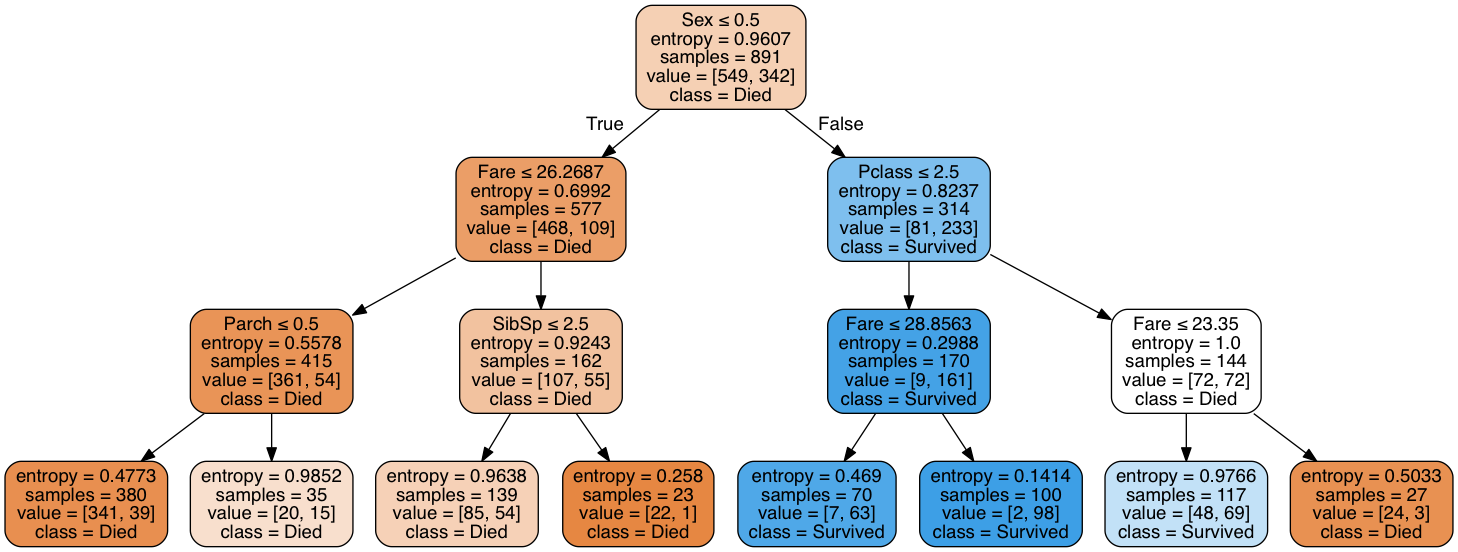

In [8]:
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                           max_depth=3)
data = numeric_data_df.drop(['Survived'], axis=1)
labels = numeric_data_df['Survived']
tree_clf = tree_clf.fit(data, labels)

# Output image
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image
dot_data = StringIO() 
skl.tree.export_graphviz(tree_clf,
                         out_file=dot_data,  
                         feature_names=data.columns,
                         class_names=['Died', 'Survived'],  
                         filled=True,
                         rounded=True,
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())  

From the decision tree I can see that sex was the key factor. Other factors that appeared more often were class, fare, siblings/spouse and children.

A woman in first or second class was more likely to survive. For men paying a larger fare helped as well.

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fit = SelectKBest(chi2, k=3).fit(data, labels)
print data.columns[fit.get_support()]

Index([u'Pclass', u'Sex', u'Fare'], dtype='object')


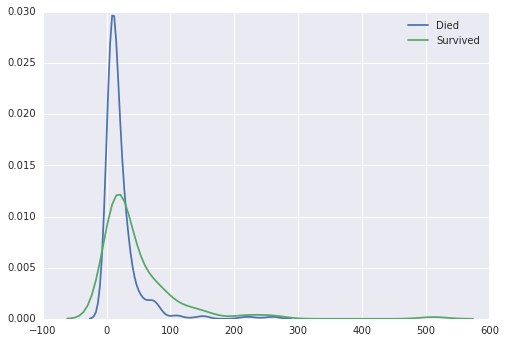

In [19]:
# Convert sex to numeric
top_factors_df = titanic_data_df[['Survived', 'Sex', 'Fare']].copy()

sex_map = {'male':0, 'female':1}
top_factors_df['Sex'] = top_factors_df['Sex'].map(sex_map)

# Plot
sns.kdeplot(top_factors_df.Fare[top_factors_df.Survived == 0], label='Died')
sns.kdeplot(top_factors_df.Fare[top_factors_df.Survived == 1], label='Survived')

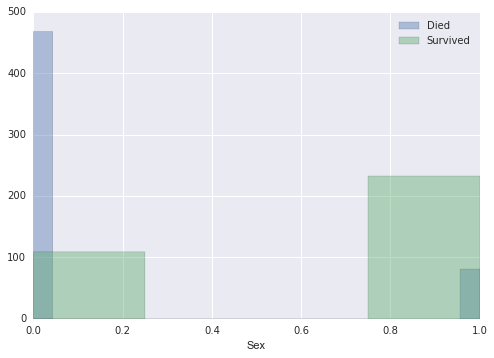

In [24]:
sns.distplot(top_factors_df.Sex[top_factors_df.Survived == 0], label='Died', kde=False)
sns.distplot(top_factors_df.Sex[top_factors_df.Survived == 1], label='Survived', kde=False)
plt.legend()

# Conclusions

Sex is by far and away the most discriminant with fare a distant second. It appears that the data is not super